# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import mdtraj as md # mdtraj unit system: nanometer / degree / picosecond
from scipy import constants as const
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
%matplotlib inline

In [3]:
ha2eV = const.physical_constants['Hartree energy in eV'][0]
bohr2ang = const.physical_constants['Bohr radius'][0]*10**10
kb = const.physical_constants['Boltzmann constant'][0]
pi = const.pi

# Functions

In [4]:
def get_monomer_structure(traj_path, top_path, lattice):
    
    ## load trajectory
    t = md.load(traj_path, top=top_path)

    ## set unit cell for all frames
    nframes = t.n_frames

    unit_cell = [[lattice, lattice, lattice],[90.0, 90.0, 90.0]]

    lattice = np.array(unit_cell[0])
    angles = np.array(unit_cell[1])

    unit_lengths = np.tile(lattice, (nframes,1))
    unit_angles = np.tile(angles, (nframes,1))

    t.unitcell_lengths = unit_lengths
    t.unitcell_angles = unit_angles
    
    # get indices for OH pairs and HOH angles, only intramolecular
    triples = []
    pairs = []

    for i in t.topology.select('name O'):
        pairs.append((i, i+1)) # OH1
        pairs.append((i, i+2)) # OH2
        triples.append((i+1, i, i+2)) # H1OH2

    pairs = np.asarray(pairs)    
    triples = np.asarray(triples)

    # compute molecular angles [°]
    angles = md.compute_angles(t, triples)*180.0/pi # per frame
    
    # compute OH distances [Angstrom]
    r_OH = md.compute_distances(t, pairs)*10.0

    return angles, r_OH

In [5]:
def get_min_dist_inter(traj_path, top_path, lattice):
    
    ## load trajectory
    t = md.load(traj_path, top=top_path)

    ## set unit cell for all frames
    nframes = t.n_frames

    unit_cell = [[lattice, lattice, lattice],[90.0, 90.0, 90.0]]

    lattice = np.array(unit_cell[0])
    angles = np.array(unit_cell[1])

    unit_lengths = np.tile(lattice, (nframes,1))
    unit_angles = np.tile(angles, (nframes,1))

    t.unitcell_lengths = unit_lengths
    t.unitcell_angles = unit_angles
    
    # compute min. dist. for OO
    pairs = []

    for i in t.topology.select('name O'):
        for j in t.topology.select('name O'):
            if i != j:
                pairs.append((i,j))     
        
    pairs = np.asarray(pairs)    
    distances = md.compute_distances(t, pairs)*10.0
       
    r_OO_min = np.amin(distances, axis=1)
    
    # compute min. dist. for OH(inter)
    pairs = []

    for i in t.topology.select('name O'):
        for j in t.topology.select('name H'):
            if j != i+1 and j != i+2:
                pairs.append((i,j))     
        
    pairs = np.asarray(pairs)    
    distances = md.compute_distances(t, pairs)*10.0
       
    r_OH_min = np.amin(distances, axis=1)
    
    # compute min. dist. for HH(inter)
    pairs = []

    for i in t.topology.select('name H'):
        for j in t.topology.select('name H'):
            if j != i and j != i+1 and j != i-1:
                pairs.append((i,j))     
        
    pairs = np.asarray(pairs)    
    distances = md.compute_distances(t, pairs)*10.0
       
    r_HH_min = np.amin(distances, axis=1)
    
    return r_OO_min, r_OH_min, r_HH_min

# Run analysis

In [6]:
traj_path = "Traj_02_350K/traj_vmd.xyz"
top_path = "Traj_02_350K/input.pdb"

lattice = 1.253

angles, r_OH = get_monomer_structure(traj_path, top_path, lattice)

traj_350K_angles_min = np.amin(angles, axis=1)
traj_350K_angles_max = np.amax(angles, axis=1)

traj_350K_r_OH_min = np.amin(r_OH, axis=1)
traj_350K_r_OH_max = np.amax(r_OH, axis=1)

nframes = angles.shape[0]

traj_350K_r_OH_min = traj_350K_r_OH_min[nframes-150:nframes]
traj_350K_r_OH_max = traj_350K_r_OH_max[nframes-150:nframes]

traj_350K_x = np.arange(0.0,1.50,0.01)

traj_350K_angles_min = traj_350K_angles_min[nframes-150:nframes]
traj_350K_angles_max = traj_350K_angles_max[nframes-150:nframes]

traj_350K_angles_mean = angles[:-150].mean()
traj_350K_r_OH_mean = r_OH[:-150].mean()

traj_350K_r_OO_inter_min, traj_350K_r_OH_inter_min, traj_350K_r_HH_inter_min = get_min_dist_inter(traj_path, top_path, lattice)

traj_350K_r_OO_inter_min = traj_350K_r_OO_inter_min[nframes-150:nframes]
traj_350K_r_OH_inter_min = traj_350K_r_OH_inter_min[nframes-150:nframes]
traj_350K_r_HH_inter_min = traj_350K_r_HH_inter_min[nframes-150:nframes]

In [7]:
traj_path = "Traj_01_325K/traj_vmd.xyz"
top_path = "Traj_01_325K/input.pdb"

lattice = 1.242

angles, r_OH = get_monomer_structure(traj_path, top_path, lattice)
traj_325K_01_r_OO_min, traj_325K_01_r_OH_min, traj_325K_01_r_HH_min = get_min_dist_inter(traj_path, top_path, lattice)

traj_325K_01_angles_min = np.amin(angles, axis=1)
traj_325K_01_angles_max = np.amax(angles, axis=1)

traj_325K_01_r_OH_min = np.amin(r_OH, axis=1)
traj_325K_01_r_OH_max = np.amax(r_OH, axis=1)

nframes = angles.shape[0]

traj_325K_01_x = np.arange(0,nframes*0.01,0.01)

traj_325K_01_r_OH_min = traj_325K_01_r_OH_min[nframes-150:nframes]
traj_325K_01_r_OH_max = traj_325K_01_r_OH_max[nframes-150:nframes]

traj_325K_01_angles_min = traj_325K_01_angles_min[nframes-150:nframes]
traj_325K_01_angles_max = traj_325K_01_angles_max[nframes-150:nframes]

traj_325K_01_angles_mean = angles[:-150].mean()
traj_325K_01_r_OH_mean = r_OH[:-150].mean()

traj_325K_01_r_OO_inter_min, traj_325K_01_r_OH_inter_min, traj_325K_01_r_HH_inter_min = get_min_dist_inter(traj_path, top_path, lattice)

traj_325K_01_r_OO_inter_min = traj_325K_01_r_OO_inter_min[nframes-150:nframes]
traj_325K_01_r_OH_inter_min = traj_325K_01_r_OH_inter_min[nframes-150:nframes]
traj_325K_01_r_HH_inter_min = traj_325K_01_r_HH_inter_min[nframes-150:nframes]

# Make plots

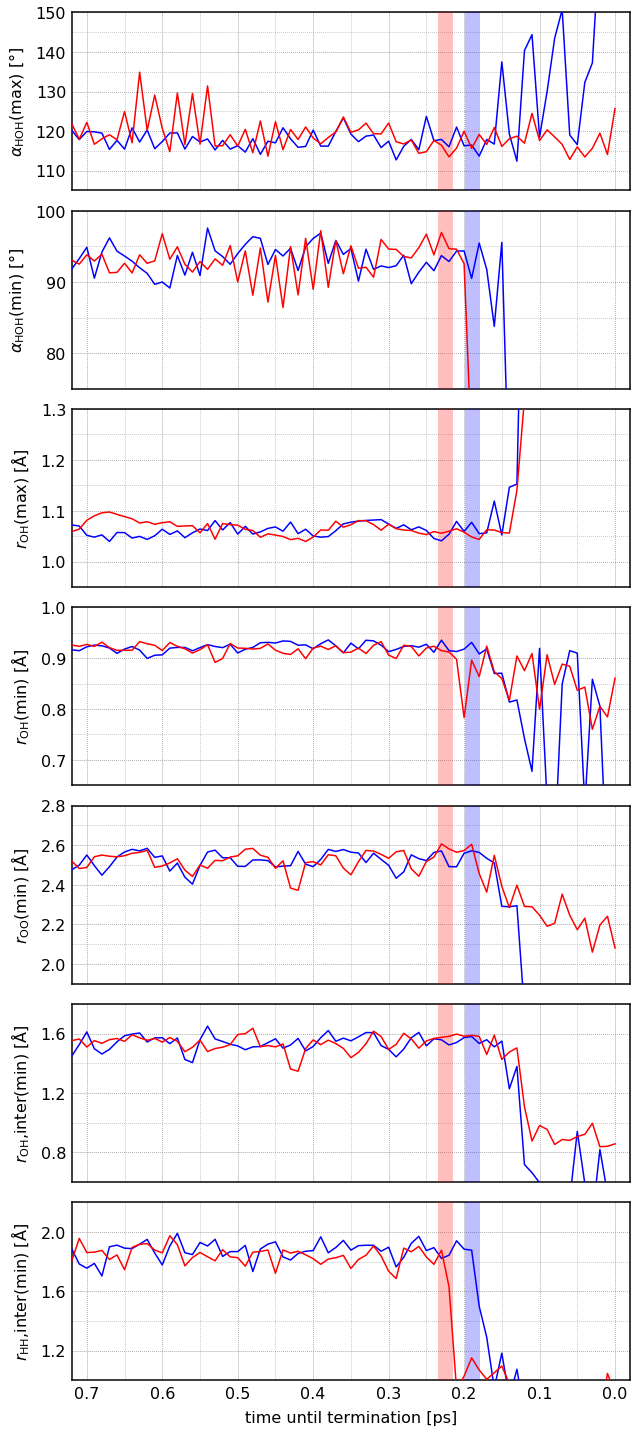

In [8]:
fig = plt.figure(figsize=(9,20))

gs = gridspec.GridSpec(7, 1)

fig.subplots_adjust(bottom=0.3)
fig.subplots_adjust(hspace=-0.1)

ax1 = fig.add_subplot(gs[0])
ax1.ticklabel_format(useOffset=False)

plt.xlim(-0.02,0.72)
plt.ylim(105,150)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(10)
ax1.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(5)
ax1.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax1.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.grid(which='both', linestyle=':', color='gray', zorder=0)

ax1.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax1.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax1.spines.values(), linewidth=1.5)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel(r'$\alpha_{\rm{HOH}}$(max) [$\degree$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_angles_max, color='blue', alpha=1.0, zorder=6)
plt.plot(traj_350K_x[::-1], traj_350K_angles_max, color='red', alpha=1.0, zorder=6)

plt.plot([0.225,0.225], [0.0,1000.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,1000.0], color='blue', alpha=0.25, lw=15, zorder=4)


ax2 = fig.add_subplot(gs[1])
ax2.ticklabel_format(useOffset=False)
plt.xlim(-0.02,0.72)
plt.ylim(75,100)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(10)
ax2.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(5)
ax2.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax2.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax2.xaxis.set_minor_locator(minorLocator)
ax2.grid(which='both', linestyle=':', color='gray', zorder=0)

ax2.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax2.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax2.spines.values(), linewidth=1.5)

plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel(r'$\alpha_{\rm{HOH}}$(min) [$\degree$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_angles_min, color='blue', alpha=1.0, zorder=6)
plt.plot(traj_350K_x[::-1], traj_350K_angles_min, color='red', alpha=1.0, zorder=6)

plt.plot([0.225,0.225], [0.0,1000.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,1000.0], color='blue', alpha=0.25, lw=15, zorder=4)


ax3 = fig.add_subplot(gs[2])
ax3.ticklabel_format(useOffset=False)
plt.xlim(-0.02,0.72)
plt.ylim(0.95,1.3)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(0.1)
ax3.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax3.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax3.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax3.xaxis.set_minor_locator(minorLocator)
ax3.grid(which='both', linestyle=':', color='gray', zorder=0)

ax3.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax3.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax3.spines.values(), linewidth=1.5)

plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel(r'$r_{\rm{OH}}$(max) [$\rm{\AA}$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_r_OH_max, color='blue', alpha=1.0, zorder=6)
plt.plot(traj_350K_x[::-1], traj_350K_r_OH_max, color='red', alpha=1.0, zorder=6)

plt.plot([0.225,0.225], [0.0,10.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,10.0], color='blue', alpha=0.25, lw=15, zorder=4)


ax4 = fig.add_subplot(gs[3])
ax4.ticklabel_format(useOffset=False)
plt.xlim(-0.02,0.72)
plt.ylim(0.65,1.0)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(0.1)
ax4.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax4.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax4.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax4.xaxis.set_minor_locator(minorLocator)
ax4.grid(which='both', linestyle=':', color='gray', zorder=0)

ax4.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax4.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax4.spines.values(), linewidth=1.5)

plt.setp(ax4.get_xticklabels(), visible=False)
plt.ylabel(r'$r_{\rm{OH}}$(min) [$\rm{\AA}$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_r_OH_min, color='blue', alpha=1.0, zorder=6, label='325K, 01')
plt.plot(traj_350K_x[::-1], traj_350K_r_OH_min, color='red', alpha=1.0, zorder=6, label='350K')

plt.plot([0.225,0.225], [0.0,10.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,10.0], color='blue', alpha=0.25, lw=15, zorder=4)


ax5 = fig.add_subplot(gs[4])
ax5.ticklabel_format(useOffset=False)
plt.xlim(-0.02,0.72)
plt.ylim(1.9,2.8)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(0.2)
ax5.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.1)
ax5.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax5.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax5.xaxis.set_minor_locator(minorLocator)
ax5.grid(which='both', linestyle=':', color='gray', zorder=0)

ax5.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax5.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax5.spines.values(), linewidth=1.5)

plt.setp(ax5.get_xticklabels(), visible=False)
plt.ylabel(r'$r_{\rm{OO}}$(min) [$\rm{\AA}$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_r_OO_inter_min, color='blue', alpha=1.0, zorder=6, label='325K, 01')
plt.plot(traj_350K_x[::-1], traj_350K_r_OO_inter_min, color='red', alpha=1.0, zorder=6, label='350K')

plt.plot([0.225,0.225], [0.0,10.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,10.0], color='blue', alpha=0.25, lw=15, zorder=4)


ax6 = fig.add_subplot(gs[5])
ax6.ticklabel_format(useOffset=False)
plt.xlim(-0.02,0.72)
plt.ylim(0.6,1.8)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(0.4)
ax6.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.2)
ax6.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax6.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax6.xaxis.set_minor_locator(minorLocator)
ax6.grid(which='both', linestyle=':', color='gray', zorder=0)

ax6.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax6.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax6.spines.values(), linewidth=1.5)

plt.setp(ax6.get_xticklabels(), visible=False)
plt.ylabel(r'$r_{\rm{OH}}$,inter(min) [$\rm{\AA}$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_r_OH_inter_min, color='blue', alpha=1.0, zorder=6, label='325K, 01')
plt.plot(traj_350K_x[::-1], traj_350K_r_OH_inter_min, color='red', alpha=1.0, zorder=6, label='350K')

plt.plot([0.225,0.225], [0.0,10.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,10.0], color='blue', alpha=0.25, lw=15, zorder=4)


ax7 = fig.add_subplot(gs[6])
ax7.ticklabel_format(useOffset=False)
plt.xlim(-0.02,0.72)
plt.ylim(1.0,2.2)

plt.gca().invert_xaxis()

majorLocator   = MultipleLocator(0.4)
ax7.yaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.2)
ax7.yaxis.set_minor_locator(minorLocator)
majorLocator   = MultipleLocator(0.1)
ax7.xaxis.set_major_locator(majorLocator)
minorLocator   = MultipleLocator(0.05)
ax7.xaxis.set_minor_locator(minorLocator)
ax7.grid(which='both', linestyle=':', color='gray', zorder=0)

ax7.tick_params(axis='x', which='major', labelsize=16)

ax7.grid(which='both', ls=':', lw=0.75, color='darkgray', zorder=0)
ax7.tick_params(axis='both', which='both', bottom=False, left=False, labelsize=16, pad=2)
plt.setp(ax7.spines.values(), linewidth=1.5)

plt.xlabel(r'time until termination [ps]', labelpad=9, size=16) 
plt.ylabel(r'$r_{\rm{HH}}$,inter(min) [$\rm{\AA}$]', labelpad=9, size=16) 

plt.plot(traj_350K_x[::-1], traj_325K_01_r_HH_inter_min, color='blue', alpha=1.0, zorder=6, label='325K, 01')
plt.plot(traj_350K_x[::-1], traj_350K_r_HH_inter_min, color='red', alpha=1.0, zorder=6, label='350K')

plt.plot([0.225,0.225], [0.0,10.0], color='red', alpha=0.25, lw=15, zorder=4)
plt.plot([0.19,0.19], [0.0,10.0], color='blue', alpha=0.25, lw=15, zorder=4)

plt.tight_layout()

plt.savefig("traj_analysis.png", dpi=300)
